# Modèle SVM pour détecter les risques de cancer cervical
par Binh Minh TRAN

## 1. Importation des packages nécessaires

In [1]:
# 1. Manipulation des données
import numpy as np
import pandas as pd

# 2. Sérialisation des objets Python
import pickle

# 3. Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Prétraitement des données
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 5. Modélisation
from sklearn import svm
from sklearn.svm import SVC

# 6. Évaluation du modèle (Model Evaluation)
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# 7. Validation croisée et recherche de paramètres
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit

#
from imblearn.over_sampling import SMOTE

# 8. Traitement des étiquettes
from sklearn.preprocessing import label_binarize

# 9. Outils supplémentaires
from collections import Counter

# 10. Fonctions personnalisées
from fonctionUtile import * 

## 2. Importation des ensembles d'entraînement et de test

In [2]:
with open('variables.pkl', 'rb') as f:
    (df, X_train, X_test, y_train, y_test,X_train_smote, y_train_smote) = pickle.load(f)

## 3. Vérification de la séparation linéaire avec SVM

Précision sur l'ensemble d'entraînement : 0.86


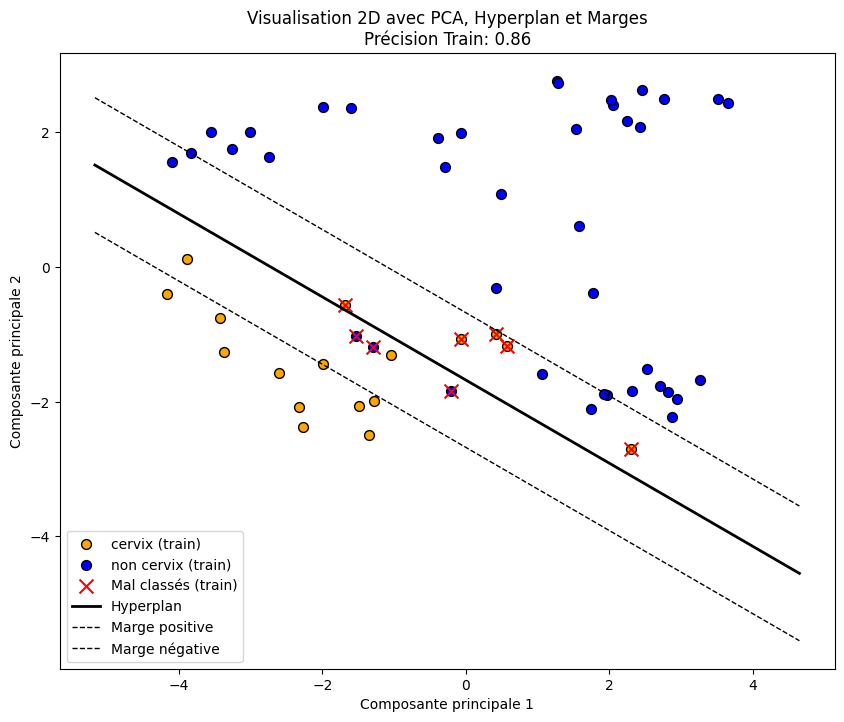

In [3]:
pca_et_visualisation(X_train, y_train)

Précision sur l'ensemble d'entraînement : 0.93


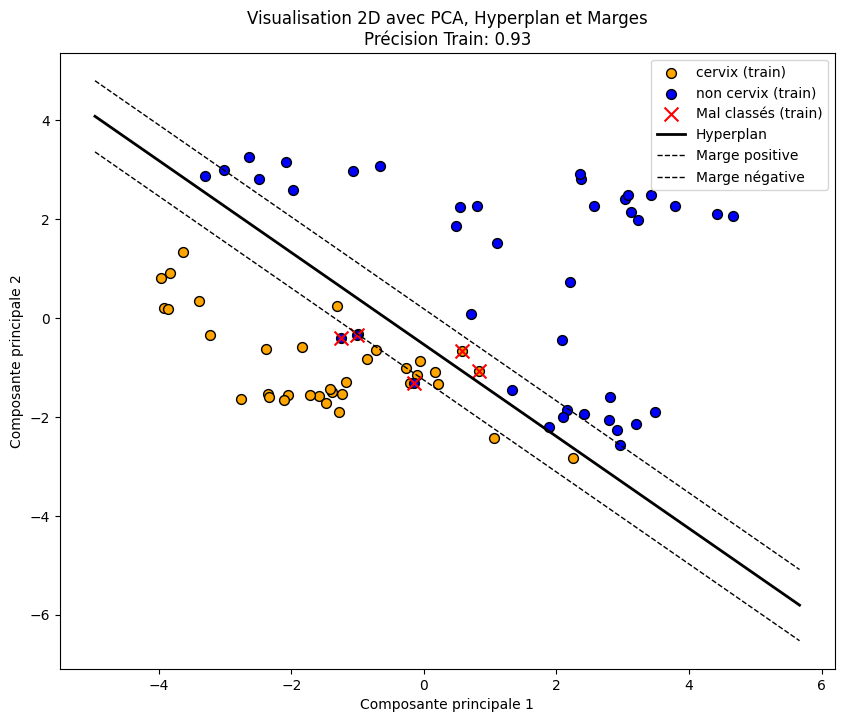

In [4]:
pca_et_visualisation(X_train_smote, y_train_smote)

## 4. SVM

### 4.1 Optimisation des hyperparamètres de SVM avec Cross-Validation

In [5]:
kernel = ["linear","rbf","poly","sigmoid"]

In [6]:
def svm_train(X_train, X_test, y_train, y_test, kernel):
    results = {
        "best_C_values": [],
        "best_model": None,
        "grid_search": None
    }
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svc = SVC(kernel=kernel)
    C_range = np.logspace(-2, 10, 13)
    param_grid = {'C': C_range}
    cv = KFold(n_splits=10, shuffle=True, random_state=18)
    
    grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_C = grid_search.best_params_['C']
    best_model = grid_search.best_estimator_
    results["best_C_values"].append(best_C)
    results["best_model"] = best_model
    results["grid_search"] = grid_search
    
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("\nPrécision moyenne sur tous les plis:", accuracy)
    print("F1-score moyen sur tous les plis:", f1)
    print("Meilleures valeurs de C pour chaque pli:", results["best_C_values"],"\n")
    
    return results

In [7]:
results_dict_smote = {}
for i in kernel:
    print("SVM - noyau: ", i)
    results_dict_smote[i] = svm_train(X_train_smote, X_test, y_train_smote, y_test, i)

SVM - noyau:  linear

Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [1.0] 

SVM - noyau:  rbf

Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [1.0] 

SVM - noyau:  poly

Précision moyenne sur tous les plis: 0.8666666666666667
F1-score moyen sur tous les plis: 0.8
Meilleures valeurs de C pour chaque pli: [10.0] 

SVM - noyau:  sigmoid

Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [1.0] 



In [8]:
for i, result in results_dict_smote.items():
    print(f"\n==== Résultats pour le noyau: {i} ====")
    print("Best parameters:", result["grid_search"].best_params_)
    print("Best score:", result["grid_search"].best_score_)
    
    cv_results_smote = pd.DataFrame(result["grid_search"].cv_results_)
    print(cv_results_smote[['param_C', 'mean_test_score']])


==== Résultats pour le noyau: linear ====
Best parameters: {'C': 1.0}
Best score: 0.9482142857142858
         param_C  mean_test_score
0   1.000000e-02         0.841071
1   1.000000e-01         0.921429
2   1.000000e+00         0.948214
3   1.000000e+01         0.948214
4   1.000000e+02         0.948214
5   1.000000e+03         0.948214
6   1.000000e+04         0.948214
7   1.000000e+05         0.948214
8   1.000000e+06         0.948214
9   1.000000e+07         0.948214
10  1.000000e+08         0.948214
11  1.000000e+09         0.948214
12  1.000000e+10         0.948214

==== Résultats pour le noyau: rbf ====
Best parameters: {'C': 1.0}
Best score: 0.9446428571428573
         param_C  mean_test_score
0   1.000000e-02         0.528571
1   1.000000e-01         0.696429
2   1.000000e+00         0.944643
3   1.000000e+01         0.944643
4   1.000000e+02         0.944643
5   1.000000e+03         0.944643
6   1.000000e+04         0.944643
7   1.000000e+05         0.944643
8   1.000000e+06 

In [9]:
results_dict= {}
for i in kernel:
    print("SVM - noyau: ", i)
    results_dict[i] = svm_train(X_train, X_test, y_train, y_test, i)

SVM - noyau:  linear

Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [1.0] 

SVM - noyau:  rbf

Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [10.0] 

SVM - noyau:  poly

Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [10.0] 

SVM - noyau:  sigmoid

Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [1.0] 



In [10]:
for i, result in results_dict.items():
    print(f"\n==== Résultats pour le noyau: {i} ====")
    print("Best parameters:", result["grid_search"].best_params_)
    print("Best score:", result["grid_search"].best_score_)
    
    cv_results = pd.DataFrame(result["grid_search"].cv_results_)
    print(cv_results[['param_C', 'mean_test_score']])


==== Résultats pour le noyau: linear ====
Best parameters: {'C': 1.0}
Best score: 0.9266666666666667
         param_C  mean_test_score
0   1.000000e-02         0.720000
1   1.000000e-01         0.823333
2   1.000000e+00         0.926667
3   1.000000e+01         0.926667
4   1.000000e+02         0.926667
5   1.000000e+03         0.926667
6   1.000000e+04         0.926667
7   1.000000e+05         0.926667
8   1.000000e+06         0.926667
9   1.000000e+07         0.926667
10  1.000000e+08         0.926667
11  1.000000e+09         0.926667
12  1.000000e+10         0.926667

==== Résultats pour le noyau: rbf ====
Best parameters: {'C': 10.0}
Best score: 0.8700000000000001
         param_C  mean_test_score
0   1.000000e-02         0.703333
1   1.000000e-01         0.703333
2   1.000000e+00         0.856667
3   1.000000e+01         0.870000
4   1.000000e+02         0.870000
5   1.000000e+03         0.870000
6   1.000000e+04         0.870000
7   1.000000e+05         0.870000
8   1.000000e+06

### 4.2 Entraînement du modèle avec le meilleur paramètre C

Après avoir trouvé la valeur optimale de C lors de la validation croisée, nous utilisons l'ensemble d'entraînement déjà divisé (avec un ratio de 70/30 -random_state = 42 dans le fichier Preparation.ipynb) pour réentraîner le modèle avec la meilleure valeur de C trouvée.

In [11]:
print(X_train_smote.shape)
print(X_test.shape)

(76, 19)
(15, 19)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) 

In [13]:
svc_best_lin = SVC(C=1, kernel='linear', probability=True)

svc_best_lin.fit(X_train_scaled, y_train_smote)
y_pred_lin = svc_best_lin.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_lin)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_lin))

Confusion Matrix:
[[11  0]
 [ 0  4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [14]:
svc_best_rbf = SVC(C=1, kernel='rbf')

svc_best_rbf.fit(X_train_scaled, y_train_smote)

y_pred_rbf = svc_best_rbf.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_rbf)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_rbf))

Confusion Matrix:
[[11  0]
 [ 0  4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Avec ces résultats, on peut dire que lorsque C augmente, le classificateur SVM tend à classer les données de manière de plus en plus précise et nette. Cependant, dans le cadre du SVM, il existe un concept appelé 'soft margins', qui signifie accepter qu'un certain nombre de points soient mal classés. Cela permet d'améliorer la généralisation du modèle.

In [15]:
svc_best_poly = SVC(C=10, kernel='poly', probability=True)

svc_best_poly.fit(X_train_scaled, y_train_smote)
y_pred_poly = svc_best_poly.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_poly)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_poly))

Confusion Matrix:
[[9 2]
 [0 4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.67      1.00      0.80         4

    accuracy                           0.87        15
   macro avg       0.83      0.91      0.85        15
weighted avg       0.91      0.87      0.87        15



In [16]:
svc_best_sig = SVC(C=1, kernel='linear', probability=True)

svc_best_sig.fit(X_train_scaled, y_train_smote)
y_pred_sig = svc_best_sig.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_sig)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_sig))

Confusion Matrix:
[[11  0]
 [ 0  4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



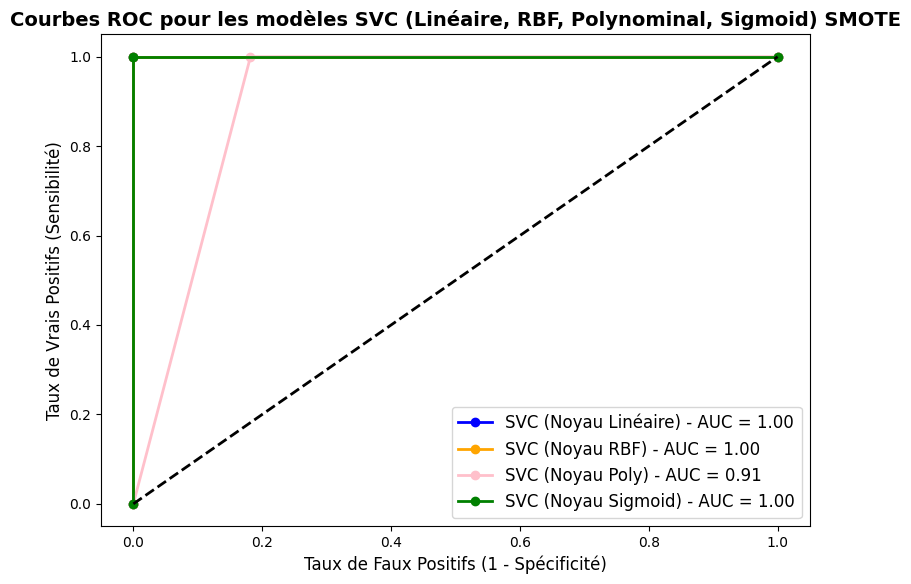

In [17]:
#SMOTE

fpr_lin, tpr_lin, _ = roc_curve(y_test, y_pred_lin)  # ROC pour le modèle SVC avec noyau linéaire
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_rbf)  # ROC pour le modèle SVC avec noyau RBF
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_poly)
fpr_sig, tpr_sig, _ = roc_curve(y_test, y_pred_sig)

auc_lin = auc(fpr_lin, tpr_lin)  # AUC pour le modèle SVC avec noyau linéaire
auc_rbf = auc(fpr_rbf, tpr_rbf)  # AUC pour le modèle SVC avec noyau RBF
auc_poly = auc(fpr_poly, tpr_poly)
auc_sig = auc(fpr_sig, tpr_sig)

plt.figure(figsize=(8, 6))

plt.plot(fpr_lin, tpr_lin, label=f'SVC (Noyau Linéaire) - AUC = {auc_lin:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='blue', color='blue')
plt.plot(fpr_rbf, tpr_rbf, label=f'SVC (Noyau RBF) - AUC = {auc_rbf:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='orange', color='orange')
plt.plot(fpr_poly, tpr_poly, label=f'SVC (Noyau Poly) - AUC = {auc_poly:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='pink', color='pink')
plt.plot(fpr_sig, tpr_sig, label=f'SVC (Noyau Sigmoid) - AUC = {auc_sig:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='green', color='green')

# Tracer la ligne diagonale (modèle aléatoire avec AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.rcParams['font.size'] = 12
plt.title('Courbes ROC pour les modèles SVC (Linéaire, RBF, Polynominal, Sigmoid) SMOTE', fontsize=14, fontweight='bold')

plt.xlabel('Taux de Faux Positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=12)

plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/ROC_SVM_SMOTE.png")
plt.show()

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [19]:
svc_best_lin = SVC(C=1, kernel='linear', probability=True)

svc_best_lin.fit(X_train_scaled, y_train)
y_pred_lin = svc_best_lin.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_lin)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_lin))

Confusion Matrix:
[[11  0]
 [ 0  4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [20]:
svc_best_rbf = SVC(C=10, kernel='rbf')

svc_best_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svc_best_rbf.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_rbf)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_rbf))

Confusion Matrix:
[[11  0]
 [ 0  4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [21]:
svc_best_poly = SVC(C=10, kernel='poly', probability=True)

svc_best_poly.fit(X_train_scaled, y_train)
y_pred_poly = svc_best_poly.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_poly)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_poly))

Confusion Matrix:
[[11  0]
 [ 0  4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [22]:
svc_best_sig = SVC(C=1, kernel='linear', probability=True)

svc_best_sig.fit(X_train_scaled, y_train)
y_pred_sig = svc_best_sig.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_sig)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_sig))

Confusion Matrix:
[[11  0]
 [ 0  4]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



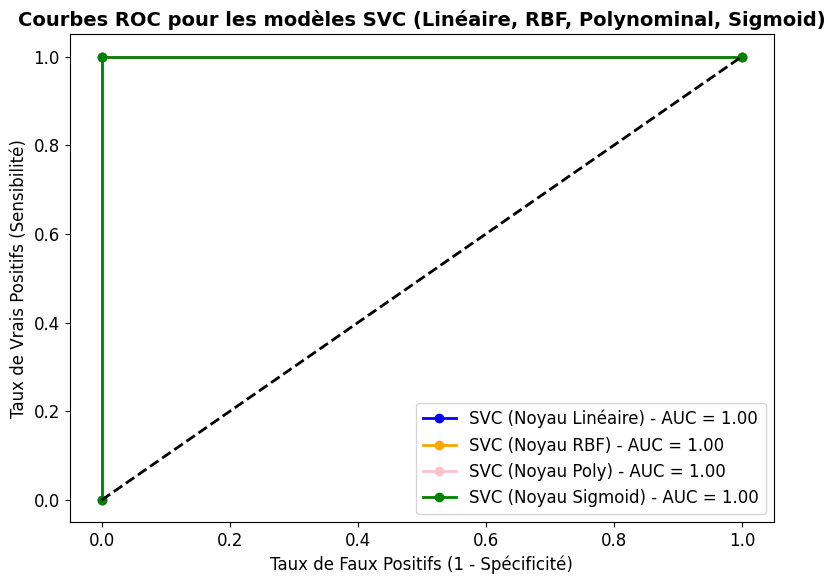

In [23]:
#Sans SMOTE

fpr_lin, tpr_lin, _ = roc_curve(y_test, y_pred_lin)  # ROC pour le modèle SVC avec noyau linéaire
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_rbf)  # ROC pour le modèle SVC avec noyau RBF
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_poly)
fpr_sig, tpr_sig, _ = roc_curve(y_test, y_pred_sig)

auc_lin = auc(fpr_lin, tpr_lin)  # AUC pour le modèle SVC avec noyau linéaire
auc_rbf = auc(fpr_rbf, tpr_rbf)  # AUC pour le modèle SVC avec noyau RBF
auc_poly = auc(fpr_poly, tpr_poly)
auc_sig = auc(fpr_sig, tpr_sig)

plt.figure(figsize=(8, 6))

plt.plot(fpr_lin, tpr_lin, label=f'SVC (Noyau Linéaire) - AUC = {auc_lin:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='blue', color='blue')
plt.plot(fpr_rbf, tpr_rbf, label=f'SVC (Noyau RBF) - AUC = {auc_rbf:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='orange', color='orange')
plt.plot(fpr_poly, tpr_poly, label=f'SVC (Noyau Poly) - AUC = {auc_poly:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='pink', color='pink')
plt.plot(fpr_sig, tpr_sig, label=f'SVC (Noyau Sigmoid) - AUC = {auc_sig:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='green', color='green')

# Tracer la ligne diagonale (modèle aléatoire avec AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.rcParams['font.size'] = 12
plt.title('Courbes ROC pour les modèles SVC (Linéaire, RBF, Polynominal, Sigmoid)', fontsize=14, fontweight='bold')

plt.xlabel('Taux de Faux Positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=12)

plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/ROC_SVM.png")
plt.show()

#### Critique 



## 5. Exporter les variables

In [24]:
roc_data_rbf = {
    'fpr_rbf': fpr_rbf,
    'tpr_rbf': tpr_rbf,
    'auc_rbf': auc_rbf
}

with open('roc_data_rbf.pkl', 'wb') as file:
    pickle.dump(roc_data_rbf, file)
print("Les données ont été enregistrées avec succès dans 'variables.pkl'.")

Les données ont été enregistrées avec succès dans 'variables.pkl'.
